In [7]:
import torch 
from torch import nn
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import skew
from scipy.stats import kurtosis
from prettytable import PrettyTable
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
import os


if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Cuda Device Available")
    print("Name of the Cuda Device: ", torch.cuda.get_device_name())
    print("GPU Computational Capablity: ", torch.cuda.get_device_capability())

else:
    device = torch.device("cpu")

#Rough Estimate made Graphically
def MultiplyPE(pe):
    pe = pe * 25
    return pe

#Scales PE for 2012 y intercept
def ScalePERatio(df):
    df['Shiller PE Ratio'] = df['Shiller PE Ratio'].apply(MultiplyPE)
    return df

    
def BuildSandPDataSet():
    df = pd.read_csv("SandP500Data.csv", sep = ',')
    
    #df.drop('Volume', inplace = True, axis=1)
    df = df.sort_index(axis=0,ascending=False).reset_index()
    df.drop('index', inplace = True, axis = 1)
    
    return df

def BuildShillerPeDataSet():
    df = pd.read_csv("ShillerPERatio.csv", sep = ',', skiprows = [0])
    
    df = df.rename(columns={'DateTime': 'Date'})
    #df['Date'] = df['Date'].apply(ChangeDateShiller)
    df = df.sort_index(axis=0,ascending=False).reset_index()
    df.drop('index', inplace = True, axis = 1)
    
    return df

def BuildDataset():
    SP = BuildSandPDataSet()
    PE = BuildShillerPeDataSet()
    df = pd.merge(SP, PE, how="inner", on=["Date"])
    df = df[['Date', 'Open', 'High', 'Low', 'Volume', 'Shiller PE Ratio', 'Close']]
    return df

def MergeByDate(df1, df2):
    dfinal = df1.merge(df2, on="Date", how = 'inner')
    return dfinal


#Looks like the derivatives of each are correlated
#Even though maybe the magnitudes are not
def GraphPEToClose(SandPData, PEData, logy = True):
    if logy == False:
        #PEData = ScalePERatio(PEData)
        title = "Graph of S&P and Schiller PE"
    else:
         title = "Graph of S&P and Schiller PE"
       
    dfinal = MergeByDate(SandPData, PEData)
    dfinal[:].plot(x='Date', y=['Close', 'Shiller PE Ratio'], figsize=(10,5), logy = logy, title = title, grid=True)

def PEGraph():
    SP = BuildSandPDataSet()
    PE = BuildShillerPeDataSet()
    GraphPEToClose(SP, PE)
    
def BuildInputSequence(dataset, window = 1, prediction = 1):
    
    features = []
    labels = []

    for i in range(0, len(dataset) - window + 1 - prediction):
        feature = []
        label = []
        for j in range(0, window):
            row = []
            row.append(np.log(dataset['Open'][i + j]))
            row.append(np.log(dataset['High'][i + j]))
            row.append(np.log(dataset['Low'][i + j]))
            row.append(np.log(dataset['Volume'][i + j]))
            row.append(np.log(dataset['Shiller PE Ratio'][i + j]))
            row.append(np.log(dataset['Close'][i + j]))
            feature.append(row)

        for j in range(0, prediction):
            label.append(np.log(dataset['Open'][i + window + j]))
            label.append(np.log(dataset['High'][i + window + j]))
            label.append(np.log(dataset['Low'][i + window + j]))
            label.append(np.log(dataset['Volume'][i + window + j]))
            label.append(np.log(dataset['Shiller PE Ratio'][i + window + j]))
            label.append(np.log(dataset['Close'])[i + window + j])

        features.append(feature)
        labels.append(label)
        
    return [features, labels]

def TrainTestDataset(window = 1, prediction = 1):
    df = BuildDataset()
    
    a = BuildInputSequence(df, window, prediction)
    
   
    X_train, X_test, Y_train, Y_test = train_test_split(a[0], a[1], test_size = 0.2)
    
    return [X_train, Y_train, X_test, Y_test]


class RNN(nn.Module):
    
    def __init__(self, input_size, output_size, hidden_size, layers):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.layers = layers
        self.rnn = nn.RNN(input_size, hidden_size, layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        out, hidden = self.rnn(x, hidden)
        out = out.contiguous().view(-1, self.hidden_size)
        out = self.fc(out)
        return out, hidden
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.layers, batch_size, self.hidden_size).to(device)
        return hidden
    
def Train(Model, X_train, Y_train, epochs, batchSize, learningRate, valid = 0):
    minValidLoss = np.inf
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(Model.parameters(), lr=learningRate)

    if valid == 1:
        val_X = X_train[300:-1]
        val_Y = Y_train[300:-1]

        X_train = X_train[:300]
        Y_train = Y_train[:300]

        X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size = 0.2)

        

        validationSet = torch.utils.data.TensorDataset(val_X, val_Y)
        validationLoader = torch.utils.data.DataLoader(dataset=validationSet, batch_size=batchSize, shuffle=True)
    
    
    dataset = torch.utils.data.TensorDataset(X_train, Y_train)
    dataLoader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batchSize, shuffle=True)
    
    for epoch in range(epochs):
        running_loss = 0.0
        epoch_steps = 0
        Model.train()
        for i, (data, label) in enumerate(dataLoader):
            data = data.to(device)
            label = label.type(torch.float32)
            label = label.to(device)

            output, hidden = Model(data)
            #output = output.squeeze(1)
            output = output.float()
            label = label.float()
            #print(str(data), "\n")
            #print(str(output), "\n")
            #print(str(label), "\n")
            loss = criterion(output, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            epoch_steps += 1
            
            #if(loss.item() < 0.01):
                #print("Done Training..")
                #return
        if epoch % 10 == 0:
            print("Epoch: " + str(epoch) + " Loss: " + str(loss.item()))
            
        if valid == 1:
            #Validation
            val_loss = 0.0
            Model.eval()
            for i, (data, label) in enumerate(validationLoader, 0):
                with torch.no_grad():
                    data = data.to(device)
                    label = label.type(torch.float32)
                    label = label.to(device)

                    output, hidden = Model(data)
                    output = output.float()
                    label = label.float()
                    loss = criterion(output, label)
                    val_loss = loss.item() * data.size(0)

            if minValidLoss > val_loss:
                print("Validation Loss Decreased to: ", val_loss, "\n")
                minValidLoss = val_loss
                torch.save(Model.state_dict(), 'saved_model.pth')   
            
        
            
    Model.load_state_dict(torch.load('saved_model.pth'))
        
            
        
        
    
#rnn = RNN(6, 32, 1)
D = TrainTestDataset(1)
X_train, Y_train, X_test, Y_test = D[0], D[1], D[2], D[3]


X_train = torch.Tensor(X_train)
Y_train = torch.Tensor(Y_train)

X_test = torch.Tensor(X_test)
Y_test = torch.Tensor(Y_test)

X_train.shape


Model = RNN(6, 6, 32, 1)
Model = Model.to(device)

Train(Model, X_train, Y_train, 200, 10, 0.01)

#Getting Input size[30]
#Expecting Output size [10, 1]

#Getting Input size[12]
#Expecting Output size [4, 1]


C:\Users\Will\anaconda3\envs\MachineLearning\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Cuda Device Available
Name of the Cuda Device:  NVIDIA GeForce RTX 3060 Laptop GPU
GPU Computational Capablity:  (8, 6)
Epoch: 0 Loss: 27.64781379699707
Epoch: 10 Loss: 0.537693977355957
Epoch: 20 Loss: 0.2626948952674866
Epoch: 30 Loss: 0.06816783547401428
Epoch: 40 Loss: 0.1658310890197754
Epoch: 50 Loss: 0.018655115738511086
Epoch: 60 Loss: 0.06597427278757095
Epoch: 70 Loss: 0.061476707458496094
Epoch: 80 Loss: 0.011918081901967525
Epoch: 90 Loss: 0.028551509603857994
Epoch: 100 Loss: 0.027670681476593018
Epoch: 110 Loss: 0.012411771342158318
Epoch: 120 Loss: 0.016600042581558228
Epoch: 130 Loss: 0.01324821263551712
Epoch: 140 Loss: 0.027199923992156982
Epoch: 150 Loss: 0.029671067371964455
Epoch: 160 Loss: 0.01613558828830719
Epoch: 170 Loss: 0.01128100324422121
Epoch: 180 Loss: 0.020401274785399437
Epoch: 190 Loss: 0.021135078743100166


In [8]:
def PredictAhead(M, XInit, FarAhead):
    output = XInit
    for _ in range(FarAhead):
        output, hidden = M(output)
        output = torch.Tensor(np.array([output.cpu().detach().numpy()])).to(device)
        #print(output)
    output = output.cpu().detach().numpy()
    return math.e**output[-1][-1][-1]

PredictAhead(Model, X_train[0:5].to(device), 7)


2802.6565688068476

In [9]:
def errorCalc(Model, length, X, Y, pred_length, dates, text, table):
    e = math.e
    errors = []
    
    for i in range(length):
        y = Y
        y = y.tolist()
        y = y[i + 5 + pred_length][-1]
        y = e**(y)
        
        
        #y = float(y)
        pred = PredictAhead(Model, X[i: i + 5].to(device), pred_length)
        errors.append(abs(float((pred - (y)) / (y))))
       
        
    if (len(X) > 300):
        d = {'Dates': dates[:len(errors)], 'Errors': errors}
    else:
        d = {'Dates': dates[(len(dates) - len(errors)):len(dates)], 'Errors': errors}
        
    
    df = pd.DataFrame(data = d)
    

    mean = sum(errors) / len(errors)
    var = sum([((x - mean) ** 2) for x in errors]) / len(errors)
    std = var ** 0.5
    skewness = skew(errors)
    kurt = kurtosis(errors)
    
    df.plot(x = 'Dates', y = 'Errors', figsize = (20, 5), grid = True, title = text)
    table.add_row([text, mean, std, skewness, kurt])
    return mean
    

def Test(Model, X_train, X_test, Y_train, Y_test):
    e = math.e
    
    data = BuildDataset().to_dict('split')['data']
    
    dates = []
    for i in range(len(data)):
        dates.append(data[i][0])
        
    myTable = PrettyTable(field_names = ["Category", "Mean", "STD", "Skewness", "Kurtosis"])
    myTable.title = "Error Statistics"
        
 
    #for one day prediction on train data
    errorCalc(Model, len(X_train) - 7, X_train, Y_train, 1, dates, "Train data with one day prediction", myTable)
    
        
    #for one day prediction on test data
    errorCalc(Model, len(X_test) - 7, X_test, Y_test, 1, dates, "Test data with one day prediction", myTable)
    
    
    #for two day prediction on train data
    errorCalc(Model, len(X_train) - 8, X_train, Y_train, 2, dates, "Train data with two days prediction", myTable)
    
    
    #for two day prediction on test data
    errorCalc(Model, len(X_test) - 8, X_test, Y_test, 2, dates, "Test data with two days prediction", myTable)

    
    #for three day prediction on train data
    errorCalc(Model, len(X_train) - 9, X_train, Y_train, 3, dates, "Train data with three days prediction", myTable)
    
    
    #for three day prediction on test data
    errorCalc(Model, len(X_test) - 9, X_test, Y_test, 3, dates, "Test data with three days prediction", myTable)
    
    
    #for four day prediction on train data
    errorCalc(Model, len(X_train) - 10, X_train, Y_train, 4, dates, "Train data with four days prediction", myTable)
    
    
    #for four day prediction on test data
    errorCalc(Model, len(X_test) - 10, X_test, Y_test, 4, dates, "Test data with four days prediction", myTable)
    
    
    print(myTable)
    
        

+---------------------------------------------------------------------------------------------------------------------------+
|                                                      Error Statistics                                                     |
+---------------------------------------+--------------------+--------------------+--------------------+--------------------+
|                Category               |        Mean        |        STD         |      Skewness      |      Kurtosis      |
+---------------------------------------+--------------------+--------------------+--------------------+--------------------+
|   Train data with one day prediction  | 1.3077785502769452 | 1.8648794094836172 | 2.977140611482829  | 10.507531444355756 |
|   Test data with one day prediction   | 1.437003419978403  | 2.021310833177417  | 2.4823549840701666 | 6.1814625610764615 |
|  Train data with two days prediction  | 2.281004324022766  | 2.8047138616613547 | 1.7035280094729832 | 2.19164765215

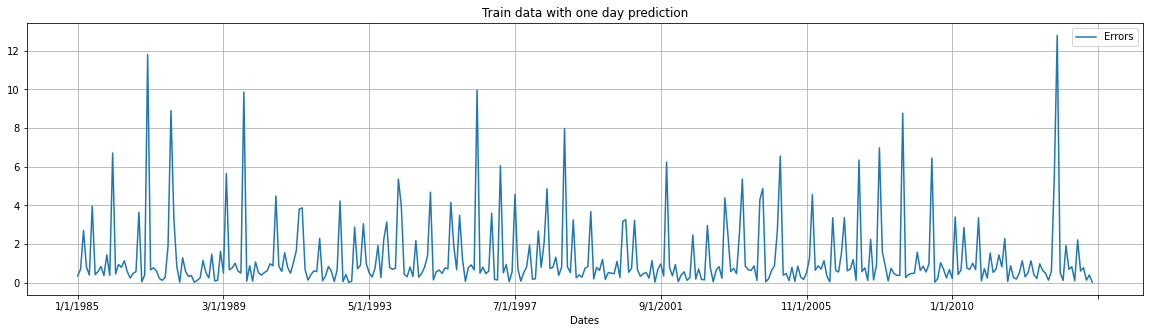

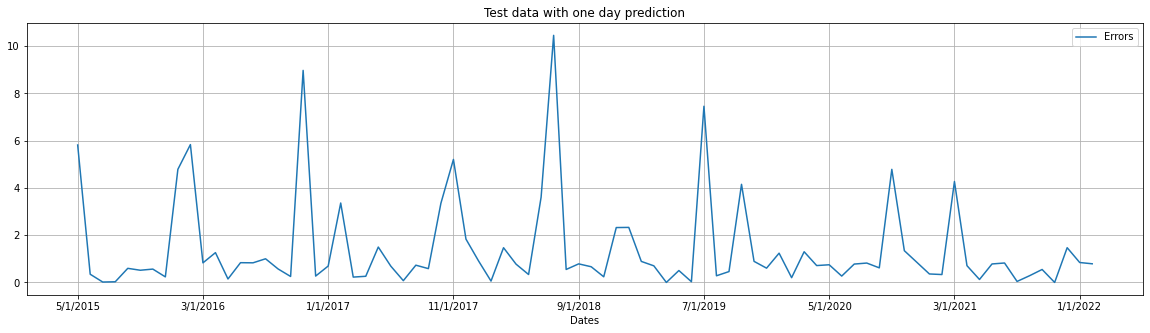

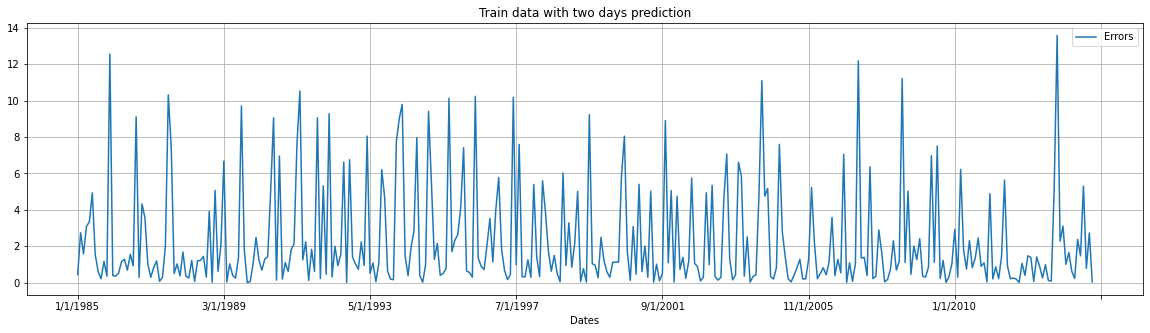

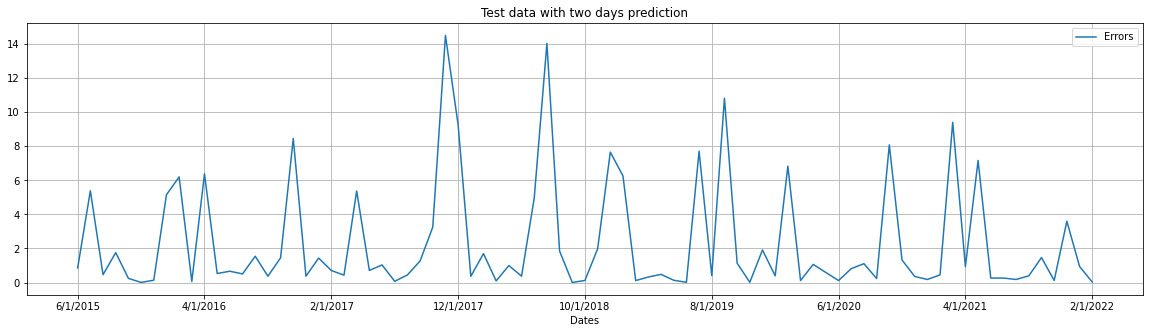

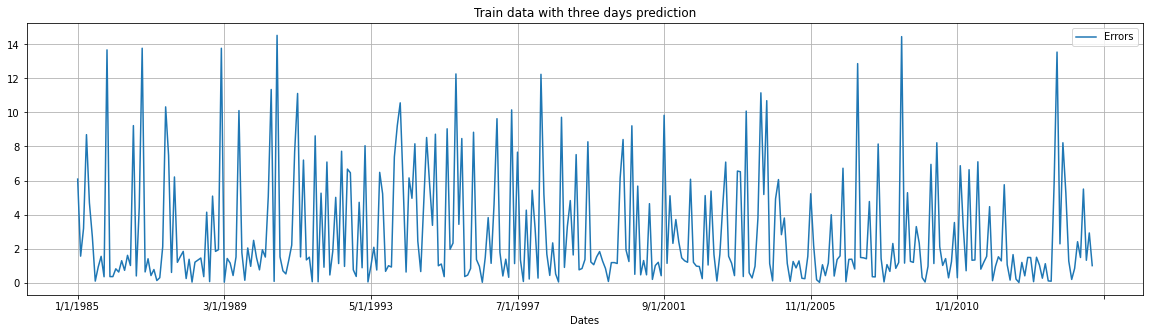

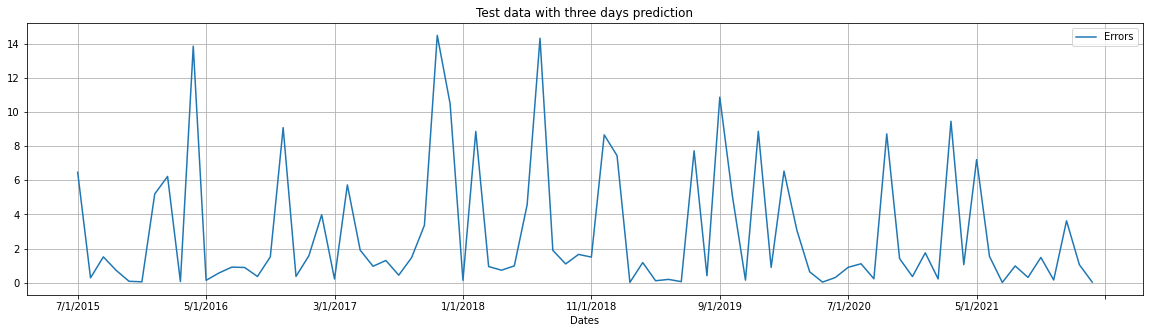

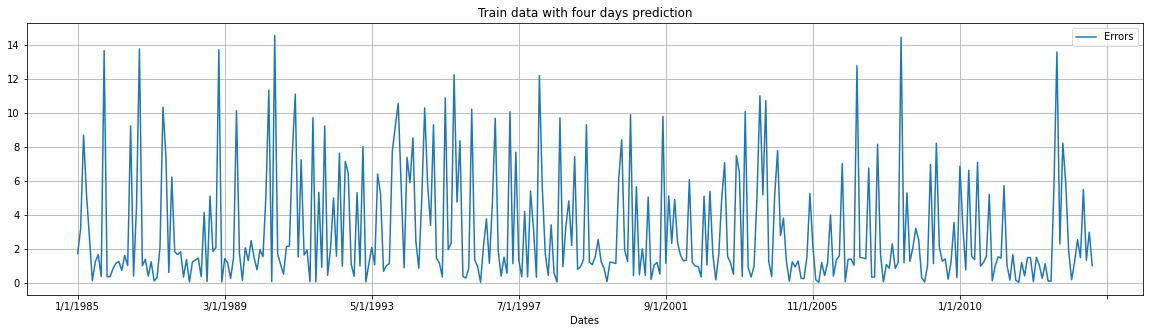

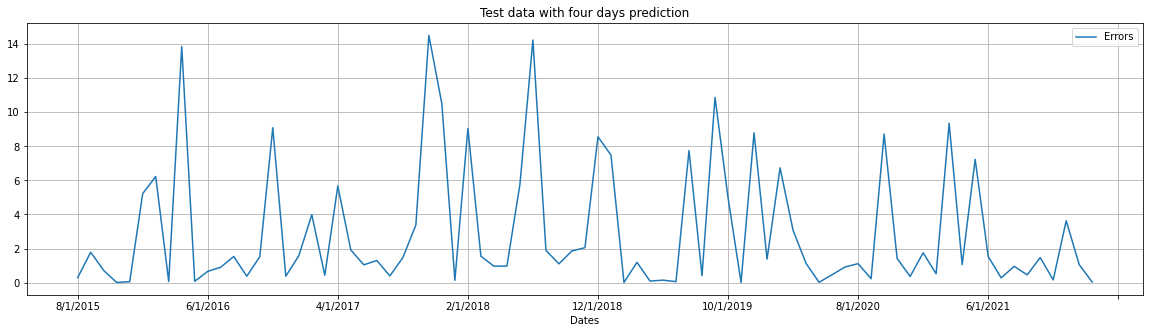

In [10]:
Test(Model, X_train, X_test, Y_train, Y_test)



In [11]:
#This is for the validation error graphs
D = TrainTestDataset(1)
X_train, Y_train, X_test, Y_test = D[0], D[1], D[2], D[3]


X_train = torch.Tensor(X_train)
Y_train = torch.Tensor(Y_train)

X_test = torch.Tensor(X_test)
Y_test = torch.Tensor(Y_test)

X_train.shape


valModel = RNN(6, 6, 32, 1)
valModel = valModel.to(device)

Train(valModel, X_train, Y_train, 200, 10, 0.01, 1)


Epoch: 0 Loss: 46.742122650146484
Validation Loss Decreased to:  207.81639099121094 

Validation Loss Decreased to:  83.11909675598145 

Validation Loss Decreased to:  10.735479593276978 

Validation Loss Decreased to:  2.4465231597423553 

Validation Loss Decreased to:  1.5800856053829193 

Epoch: 10 Loss: 0.5750959515571594
Validation Loss Decreased to:  1.2184565514326096 

Epoch: 20 Loss: 0.9112237691879272
Validation Loss Decreased to:  1.1335846036672592 

Validation Loss Decreased to:  1.0566356033086777 

Validation Loss Decreased to:  0.7442799210548401 

Validation Loss Decreased to:  0.5905282869935036 

Epoch: 30 Loss: 0.20660585165023804
Validation Loss Decreased to:  0.5297185480594635 

Validation Loss Decreased to:  0.49694400280714035 

Epoch: 40 Loss: 0.14117813110351562
Validation Loss Decreased to:  0.40315181016921997 

Validation Loss Decreased to:  0.3295421227812767 

Validation Loss Decreased to:  0.2241411805152893 

Epoch: 50 Loss: 0.10875412821769714
Validat

+---------------------------------------------------------------------------------------------------------------------------+
|                                                      Error Statistics                                                     |
+---------------------------------------+--------------------+--------------------+--------------------+--------------------+
|                Category               |        Mean        |        STD         |      Skewness      |      Kurtosis      |
+---------------------------------------+--------------------+--------------------+--------------------+--------------------+
|   Train data with one day prediction  | 1.3039367959055683 | 1.9462333177714175 | 3.182573415893104  | 12.523093280463279 |
|   Test data with one day prediction   | 1.4346364821101085 | 2.284249878712117  | 3.332145512552497  | 12.079129679041767 |
|  Train data with two days prediction  | 1.4162497178402391 | 1.8724906274226765 | 2.8476021090633643 | 10.5643659233

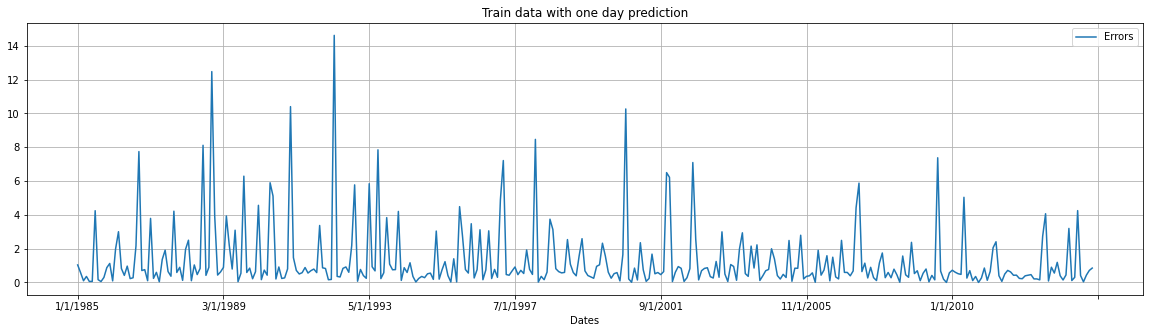

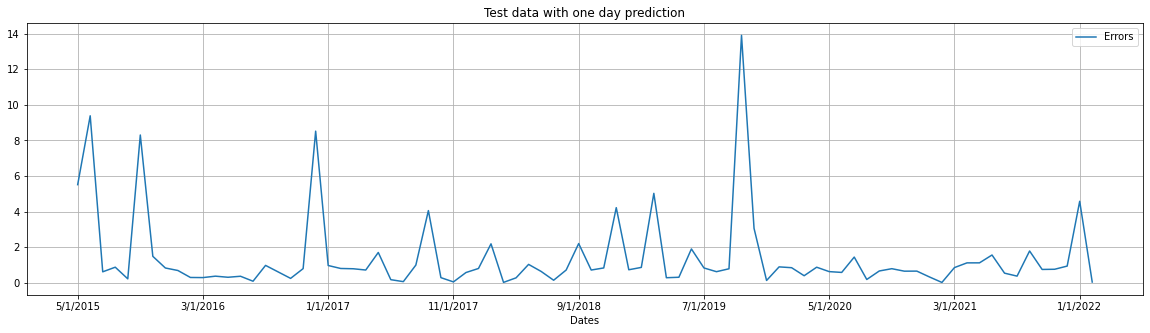

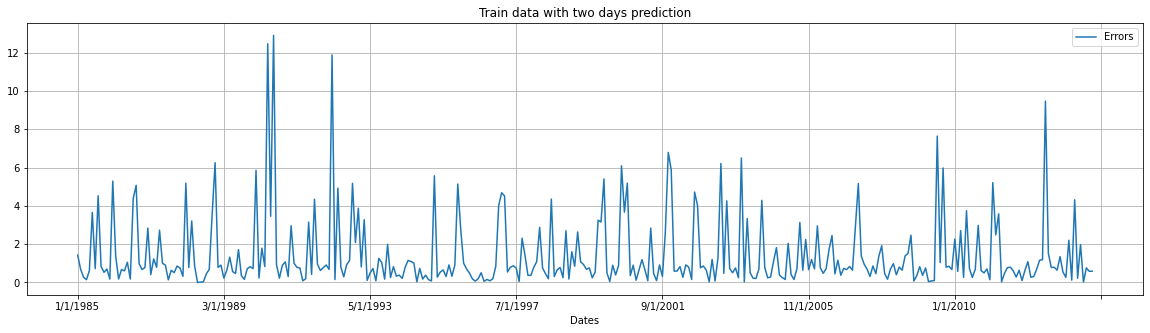

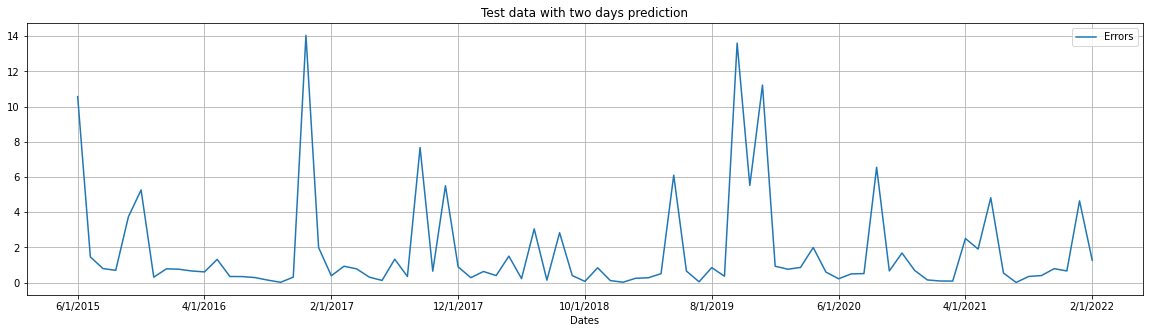

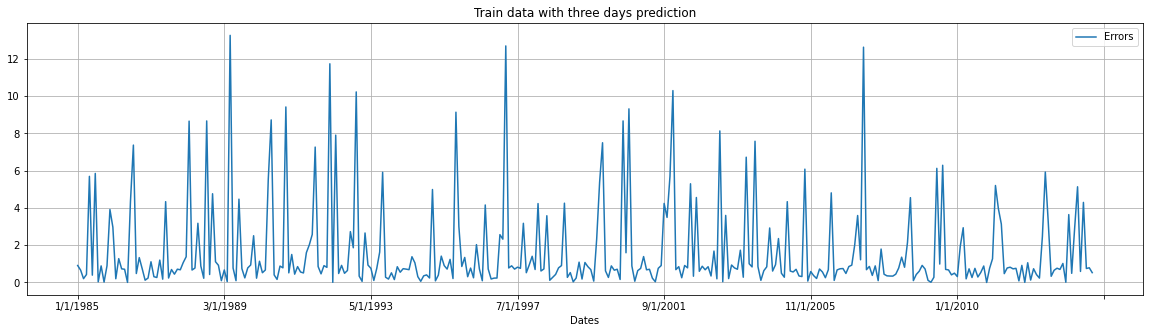

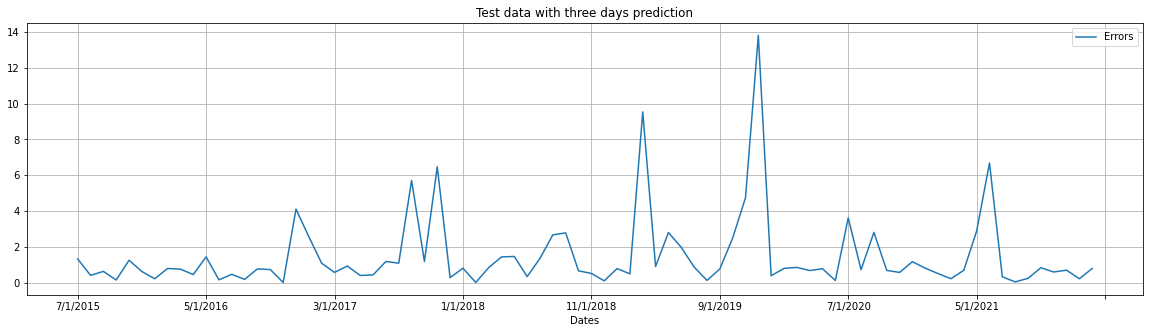

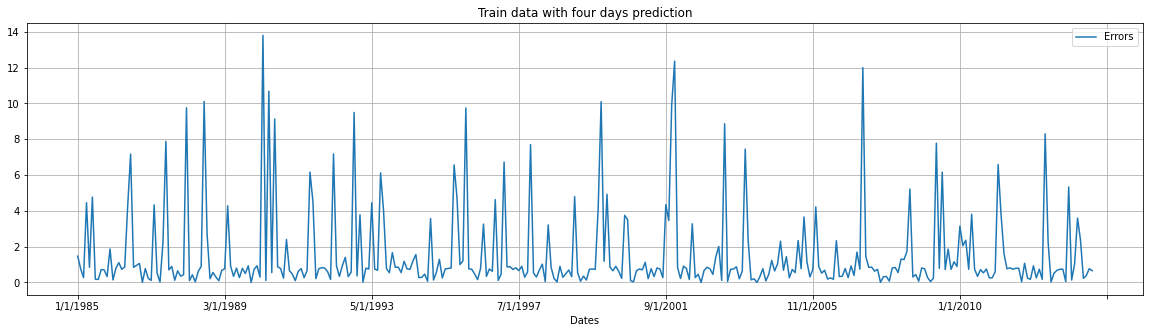

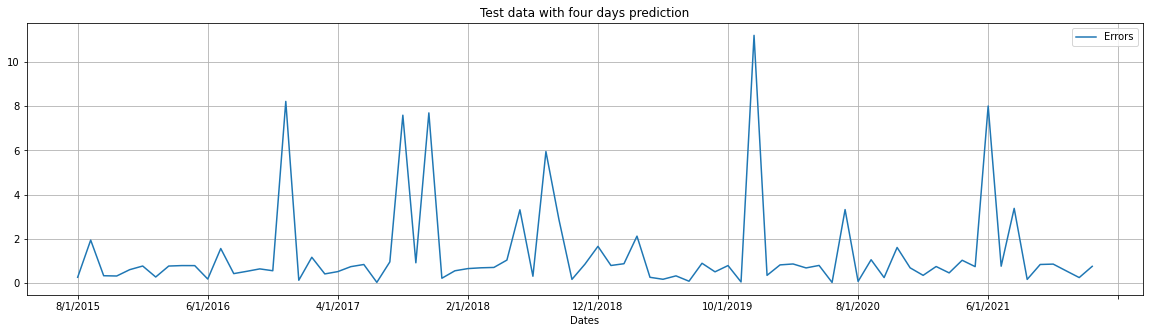

In [12]:
Test(valModel, X_train, X_test, Y_train, Y_test)

In [13]:
#the stds themselves given by the assignment are too small, 
#so I multiplied it by 5000

import random

def Corrupt(std):
    
    df = BuildDataset()
    
    for i in range(len(df)):
        if (i % 5 == 0):
            x = np.random.normal(loc = 0.0, scale = 50 * std)
           
            df.loc[i, 'Close'] += x
            if df.loc[i, 'Close'] < 0:
                df.loc[i, 'Close'] == 0
            
            
    
    a = BuildInputSequence(df)
   
    X_train, X_test, Y_train, Y_test = train_test_split(a[0], a[1], test_size = 0.2)
    
    df = BuildDataset()
    
    a = BuildInputSequence(df)
    
    X_train, X_test2, Y_train, Y_test2 = train_test_split(a[0], a[1], test_size = 0.2)
    
    
    return [X_train, Y_train, X_test, Y_test]

def testCorrupt(stds):
    models = []
    Xs = []
    Ys = []
    for i in range(len(stds)):
        C = Corrupt(stds[i])
        X_train, Y_train, X_test, Y_test = C[0], C[1], C[2], C[3]
        
        X_train = torch.Tensor(X_train)
        Y_train = torch.Tensor(Y_train)

        X_test = torch.Tensor(X_test)
        Y_test = torch.Tensor(Y_test)

        X_train.shape  
        
        CModel = RNN(6, 6, 32, 1)
        CModel = CModel.to(device)
        
        Train(CModel, X_train, Y_train, 200, 10, 0.01)
        
        models.append(CModel)
        Xs.append(X_test)
        Ys.append(Y_test)
        
        
    return [models, Xs, Ys]

In [ ]:
stds = [0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1]

models = testCorrupt(stds)[0]
Xs = testCorrupt(stds)[1]
Ys = testCorrupt(stds)[2]

Epoch: 0 Loss: 24.50904655456543
Epoch: 10 Loss: 0.8538000583648682
Epoch: 20 Loss: 0.7057339549064636
Epoch: 30 Loss: 0.08208171278238297
Epoch: 40 Loss: 0.08064927160739899
Epoch: 50 Loss: 0.09969862550497055
Epoch: 60 Loss: 0.016948729753494263
Epoch: 70 Loss: 0.010604308918118477
Epoch: 80 Loss: 0.05938427522778511
Epoch: 90 Loss: 0.05721304193139076
Epoch: 100 Loss: 0.026976866647601128
Epoch: 110 Loss: 0.045224349945783615
Epoch: 120 Loss: 0.017594434320926666
Epoch: 130 Loss: 0.04962455481290817
Epoch: 140 Loss: 0.04191747307777405
Epoch: 150 Loss: 0.026448450982570648
Epoch: 160 Loss: 0.02258010394871235
Epoch: 170 Loss: 0.03314528986811638
Epoch: 180 Loss: 0.04986504837870598
Epoch: 190 Loss: 0.021780891343951225
Epoch: 0 Loss: 29.897735595703125
Epoch: 10 Loss: 1.4534344673156738
Epoch: 20 Loss: 0.2693916857242584
Epoch: 30 Loss: 0.582995593547821
Epoch: 40 Loss: 0.8187451958656311
Epoch: 50 Loss: 0.9994440078735352
Epoch: 60 Loss: 0.8676488399505615
Epoch: 70 Loss: 0.4281112

Epoch: 60 Loss: 0.7407190203666687
Epoch: 70 Loss: 0.8535032272338867
Epoch: 80 Loss: 0.29640457034111023
Epoch: 90 Loss: 0.17307813465595245
Epoch: 100 Loss: 0.02055453695356846
Epoch: 110 Loss: 0.048538435250520706
Epoch: 120 Loss: 0.03796374052762985
Epoch: 130 Loss: 0.07834592461585999
Epoch: 140 Loss: 0.04413469135761261
Epoch: 150 Loss: 0.11781516671180725
Epoch: 160 Loss: 0.09709300100803375
Epoch: 170 Loss: 0.05289073660969734
Epoch: 180 Loss: 0.14554238319396973
Epoch: 190 Loss: 0.14353039860725403
Epoch: 0 Loss: 27.02769660949707
Epoch: 10 Loss: 0.77100670337677
Epoch: 20 Loss: 0.5475098490715027
Epoch: 30 Loss: 0.6910429000854492
Epoch: 40 Loss: 0.16501344740390778
Epoch: 50 Loss: 0.056669898331165314
Epoch: 60 Loss: 0.0398162379860878
Epoch: 70 Loss: 0.08562722057104111
Epoch: 80 Loss: 0.05075913667678833
Epoch: 90 Loss: 0.023061305284500122
Epoch: 100 Loss: 0.014169352129101753
Epoch: 110 Loss: 0.08594383299350739
Epoch: 120 Loss: 0.014909699559211731
Epoch: 130 Loss: 0.02

In [ ]:
def errorCalcSTD(Model, std, length, X, Y, pred_length, table, df):
    e = math.e
    errors = []
    
    for i in range(length):
        y = Y
        y = y.tolist()
        y = y[i + 5 + pred_length][-1]
        y = e**(y)
        
        
        #y = float(y)
        pred = PredictAhead(Model, X[i: i + 5].to(device), pred_length)
        errors.append(abs(float((pred - (y)) / (y))))
    
       
    column = pd.DataFrame({"STD of " + str(std): errors})
    df = df.join(column)
    return df
   
    #table.add_column(errors)

In [ ]:
from tabulate import tabulate
e = math.e
    
data = BuildDataset().to_dict('split')['data']
    
dates = []
for i in range(len(data)):
    dates.append(data[i][0])
    
dates = dates[len(dates) - len(X_test):]
fields = ["Dates"]
fields.append(stds)


for i in range(4):
    myTable = PrettyTable(field_names = fields)
    #myTable.title = "Perturbed Error Statistics for " + str(i + 1) + " Day Predictions"
    #myTable.add_column(dates)

    df = pd.DataFrame({'Dates': dates[6 + i + 1:]})
    for j in range(len(models)):
        df = errorCalcSTD(models[j], stds[j], len(X_test) - 6 - i - 1, Xs[j], Ys[j], i + 1, myTable, df)
        
    print("Prediction Range of " + str(i + 1) + " Days")
    print(tabulate(df, tablefmt = 'psql'))
    df.plot(title = "Prediction Range of " + str(i + 1) + " Days", x = 'Dates', y = ['STD of 0.001', 'STD of 0.002', 'STD of 0.003', 'STD of 0.005', 'STD of 0.01', 'STD of 0.02', 'STD of 0.03', 'STD of 0.05', 'STD of 0.1'], figsize = (40, 20), marker = 'o')